## Prepare

### Install dependencies
- `fastai` - machine learning library
- `librosa` - open `.wav` files and convert to spectrograms
- `matplotlib` - plot waveforms and save generated spectrograms as `.png` files

In [ ]:
!pip3 install fastai librosa matplotlib

### Download the training dataset

Source: https://magenta.tensorflow.org/datasets/nsynth

We only download the validation set, of 12k examples rather than the substantially larger training set, as it's a sufficient amount of data to experiment with. Download to the `training-data` directory in the root of the repository, so it can be shared by other projects and it is also part of `.gitignore`.

In [ ]:
import requests

url = 'http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz'
response = requests.get(url)

with open('../../training-data/nsynth-test.jsonwav.tar.gz', 'wb') as f:
    f.write(response.content)

### Extract the downloaded dataset

In [ ]:
import tarfile

with tarfile.open('../../training-data/nsynth-valid.jsonwav.tar.gz', 'r:gz') as f:
    f.extractall('../../training-data/')

### Load the example metadata

The metadata is located in `examples.json` in the extracted directory.

In [117]:
import json

examples = []
with open('../../training-data/nsynth-valid/examples.json') as f:
    examples = json.load(f)

first_20_examples = dict(list(examples.items())[:20])
first_example = list(examples.items())[0][1]

### Plot the first waveform spectrogram

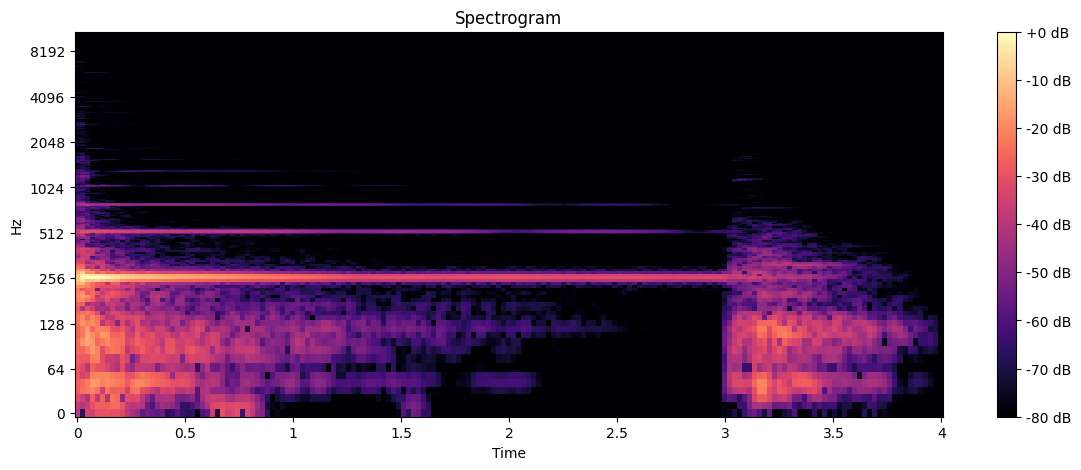

In [118]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load the audio file
y, sample_rate = librosa.load('../../training-data/nsynth-valid/audio/' + first_example['note_str'] + '.wav', sr=first_example['sample_rate'])

# Compute the STFT
D = librosa.stft(y)

# Convert to dB
D_db = librosa.amplitude_to_db(abs(D), ref=np.max)

# Display the spectrogram
plt.figure(figsize=(14, 5))
librosa.display.specshow(D_db, sr=sample_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

### Determine the frequency from the MIDI note

For details on how MIDI notes are converted to frequencies, see [this link](https://newt.phys.unsw.edu.au/jw/notes.html). The frequency $f_{m}$ of the MIDI note with number $m$ is given by:

$$ f_m = 2^{(m - 69)/12} \times 440 \mathrm{Hz} $$

In [119]:
m = first_example['pitch']
def midi_frequency(m):
    return 440 * 2 ** ((m - 69) / 12)

print(f'The note has has MIDI number: {m}, corresponding to {midi_frequency(m)} Hz')

The note has has MIDI number: 60, corresponding to 261.6255653005986 Hz


## Creating the model

Our dataset consists of musical notes, which each correspond to particular frequencies. In practice, we may encounter musical notes that are not in tune, and frequency is a continuous number. Therefore, we will build a regression model, mapping a spectrogram to a single scalar value. Since musical notes are a power series in frequency, we take the log of the frequency. This way, a mean square error loss function will give us a loss proportional to the square offset in number of notes from the actual note.

### Building the Dataset

In [142]:
from torch.utils.data import Dataset
import torch.nn.functional as F
import json
import random
from fastai.vision.all import *
import librosa

class SpectrogramDataset(Dataset):
    def __init__(self, path, examples=None, seed=42):
        self.path = path
        if examples is None:
            self.examples = list(json.load(open(f'{path}/examples.json')).items())
            self.examples.sort(key=lambda x: x[0])
        else:
            self.examples = examples
        if seed is not None:
            rng = random.Random(seed)
            rng.shuffle(self.examples)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        if isinstance(idx, slice):
            return SpectrogramDataset(
                self.path, examples=self.examples[idx], seed=None)
        else:
            example = self.examples[idx]
            y, _ = librosa.load(f'{self.path}/audio/{example[0]}' + '.wav', sr=example[1]['sample_rate'])
            ft = librosa.stft(y)
            ft_db = librosa.amplitude_to_db(abs(ft), ref=np.max)

            # Convert to PyTorch tensor and add a channel dimension
            input_tensor = tensor(ft_db).unsqueeze(0)
            target_tensor = torch.log2(tensor(midi_frequency(example[1]['pitch'])))

            return input_tensor.float(), target_tensor.float()

### Create the DataLoaders

In [143]:
ds = SpectrogramDataset('../../training-data/nsynth-valid')
ds_length = len(ds)

## Split the dataset into training and validation sets
train_ds = ds[:int(ds_length * 0.8)]
valid_ds = ds[int(ds_length * 0.8):]

dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=32, device=default_device())

### Check the DataLoaders

Since we've defined our own `Dataset`, `fastai` doesn't know how to render our data batches automatically. We'll have to write our own code to display some examples to check they look sensible.

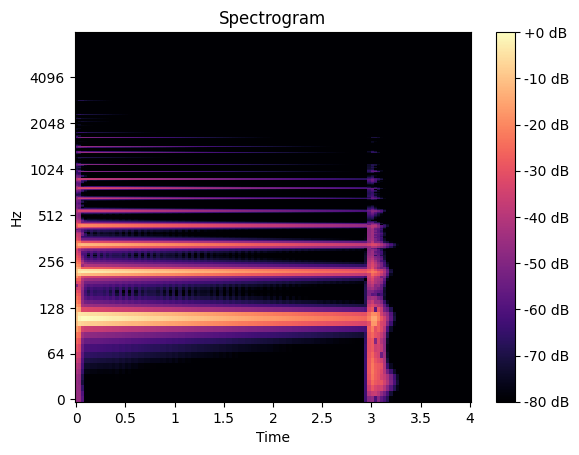

Frequency: 110.0


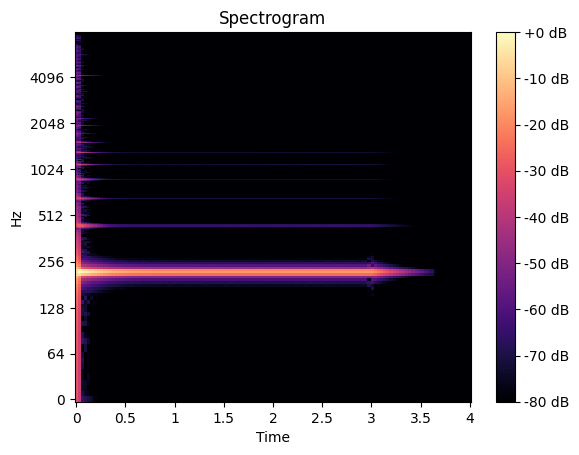

Frequency: 220.0


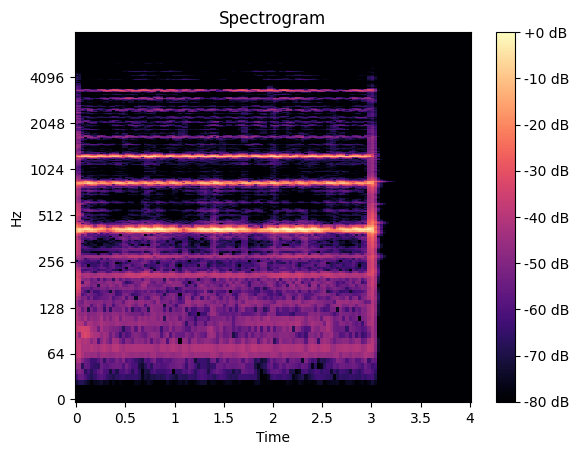

Frequency: 415.3047790527344


In [144]:
import matplotlib.pyplot as plt

xs, ys = dls.one_batch()
for idx in range(3):
    x, y = xs[idx][0], ys[idx]
    
    librosa.display.specshow(np.array(x.to('cpu')), sr=16000, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.show()

    print(f'Frequency: {2 ** y}')

### Create the learner

We create a vision learner with a single scalar output. We are working with spectrogram data, which only has a single channel as opposed to the three (RGB) channels for image data. We therefore have to swap out the first layer of our neural network as well. Swapping out the first layer would randomise its weights and cause the weights in the remaining layers to be effectively useless. However, we can simply set the values of the weights in the new first layer as the average of the original pretrained weights between the RGB channels.

In [146]:
learner = vision_learner(
    dls, resnet34, 
    n_in=1, # spectrograms have a single channel 
    n_out=1, # the target is a single number
    loss_func=MSELossFlat(), 
    metrics=[mae])

### Train the model

We once again train the model in two stages: we first train the head which strated with random weights, and then we unfreeze and train the whole model.

In [147]:
learner.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,mae,time


In [94]:
learner.unfreeze()
learner.fit_one_cycle(10, slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,mae,time
0,0.652814,0.097549,0.239377,14:05
1,0.690402,0.103604,0.228014,13:16
2,0.712263,0.087786,0.230836,13:16
3,0.650435,0.065276,0.173935,13:10
4,0.611617,0.163163,0.340483,13:20
5,0.508884,0.092160,0.243505,13:08
6,0.462252,0.076108,0.206760,13:13
7,0.485989,0.041988,0.122749,13:09
8,0.479100,0.065146,0.192391,13:03
9,0.475303,0.036703,0.098793,13:14


We note that the validation loss is consistently significantly lower than the training loss. This is because of the dropout layer in the model head, which is only in effect during training, and not evaluation. Dropout is a regularisation technique used to prevent overfitting, by setting a fraction of the input units to a layer to zero at each update during training, to prevent the model from becoming overly reliant on a single feature.

### Testing out the model

In [13]:
def midi_note(freq):
    return 69 + 12 * np.log2(freq / 440)

for example in first_20_examples.items():
    y, _ = librosa.load(f'../../training-data/nsynth-valid/audio/{example[0]}.wav')
    ft = librosa.stft(y)
    ft_db = librosa.amplitude_to_db(abs(ft), ref=np.max)
    input_tensor = tensor(ft_db).unsqueeze(0).unsqueeze(0).to(default_device())

    output_tensor, _, _ = learner.predict(input_tensor.float())
    midi_note_output = midi_note(2 ** output_tensor.item())
    
    print(f'Actual note: {example[1]["pitch"]}, predicted note: {midi_note_output}')
    print(f'Actual frequency: {midi_frequency(example[1]["pitch"])}, predicted frequency: {2 ** output_tensor.item()}')
    print('')

Actual note: 60, predicted note: 59.55428646504784
Actual frequency: 261.6255653005986, predicted frequency: 254.97587125488164



Actual note: 50, predicted note: 49.75219868123436
Actual frequency: 146.8323839587038, predicted frequency: 144.74565888509693



Actual note: 52, predicted note: 52.30525539815331
Actual frequency: 164.81377845643496, predicted frequency: 167.7455863009742



Actual note: 64, predicted note: 64.29212902486229
Actual frequency: 329.6275569128699, predicted frequency: 335.2368965670114



Actual note: 30, predicted note: 30.78953884541893
Actual frequency: 46.2493028389543, predicted frequency: 48.40736357579371



Actual note: 40, predicted note: 40.02992199361229
Actual frequency: 82.4068892282175, predicted frequency: 82.5494413298013



Actual note: 83, predicted note: 83.95639751851463
Actual frequency: 987.7666025122483, predicted frequency: 1043.8698798543214



Actual note: 33, predicted note: 34.853335842489244
Actual frequency: 55.0, predicted frequency: 61.2146207045222



Actual note: 28, predicted note: 30.002139553426737
Actual frequency: 41.20344461410875, predicted frequency: 46.25501893316151



Actual note: 72, predicted note: 71.71565960347557
Actual frequency: 523.2511306011972, predicted frequency: 514.7273673502659



Actual note: 53, predicted note: 53.64480923116112
Actual frequency: 174.61411571650194, predicted frequency: 181.24036394508155



Actual note: 62, predicted note: 61.84152553975487
Actual frequency: 293.6647679174076, predicted frequency: 290.98887255852117



Actual note: 86, predicted note: 84.23223446309471
Actual frequency: 1174.6590716696303, predicted frequency: 1060.6350285049652



Actual note: 91, predicted note: 88.8263735622158
Actual frequency: 1567.981743926997, predicted frequency: 1382.9732251888713



Actual note: 39, predicted note: 41.83293865620995
Actual frequency: 77.78174593052023, predicted frequency: 91.61030167280018



Actual note: 89, predicted note: 87.37787197530174
Actual frequency: 1396.9129257320155, predicted frequency: 1271.9701020463806



Actual note: 48, predicted note: 48.73279331624413
Actual frequency: 130.8127826502993, predicted frequency: 136.4686561100623



Actual note: 94, predicted note: 91.96953915059471
Actual frequency: 1864.6550460723597, predicted frequency: 1658.29846625328



Actual note: 85, predicted note: 83.9268832057705
Actual frequency: 1108.7305239074883, predicted frequency: 1042.0917924175085



Actual note: 48, predicted note: 49.07464550435448
Actual frequency: 130.8127826502993, predicted frequency: 139.19016885800838

